In [1]:
import gym
import pandas as pd
import seaborn as sns
from cpr_gym import protocols

/home/patrik/devel/cpr/_venv/lib64/python3.10/site-packages/gym/wrappers/monitoring/video_recorder.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.spawn


In [2]:
target_block_interval = 1

In [3]:
def episode(activation_delay=1, alpha=0.25, policy="honest"):
        env = gym.make(
            "cpr-v0",
            proto=protocols.nakamoto(),
            max_steps=2016,
            alpha=alpha,
            gamma=0.5,
            defenders=2,
            activation_delay=activation_delay,
        )
        policy = env.policies[policy]
        obs = env.reset()
        done = False
        n_pow = 0
        while not done:
            obs, _, done, info = env.step(policy(obs))
            n_pow += info["reward_n_pows"]
        observed_block_interval = info["simulator_clock_rewarded"] / n_pow
        return observed_block_interval

In [4]:
def rollout(n_episodes = 250, policy="honest", alpha=0.25):
    ad = [None] * n_episodes
    ad[0] = target_block_interval
    obi = [None] * n_episodes
    for i in range(0, n_episodes - 1):
        obi[i] = episode(ad[i], policy=policy, alpha=alpha)
        ad[i+1] = ad[i] * (target_block_interval / obi[i])
    return pd.DataFrame({"episode": range(n_episodes), "activation_delay": ad, "observed_block_interval": obi, "alpha": alpha, "policy": policy})

d = pd.concat([ rollout(policy=p, alpha=a) for a in [.1, .25, .33] for p in ["honest", "sapirshtein-2016-sm1"]])


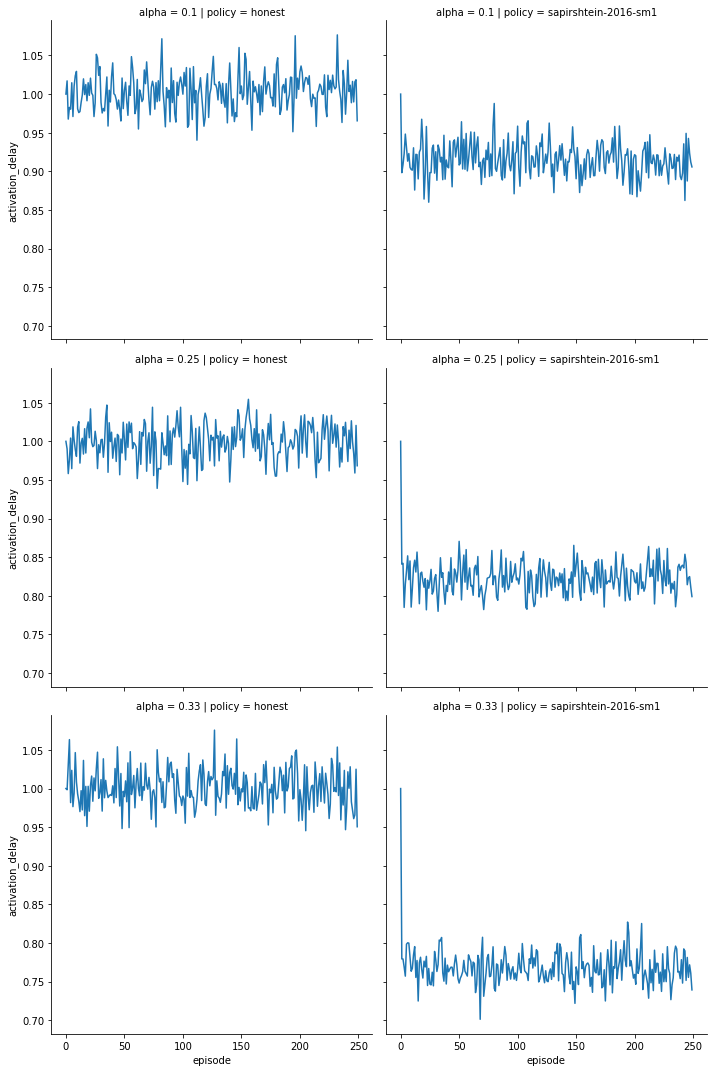

In [5]:
sns.relplot(data=d, kind="line", x="episode", y="activation_delay", col="policy", row="alpha")

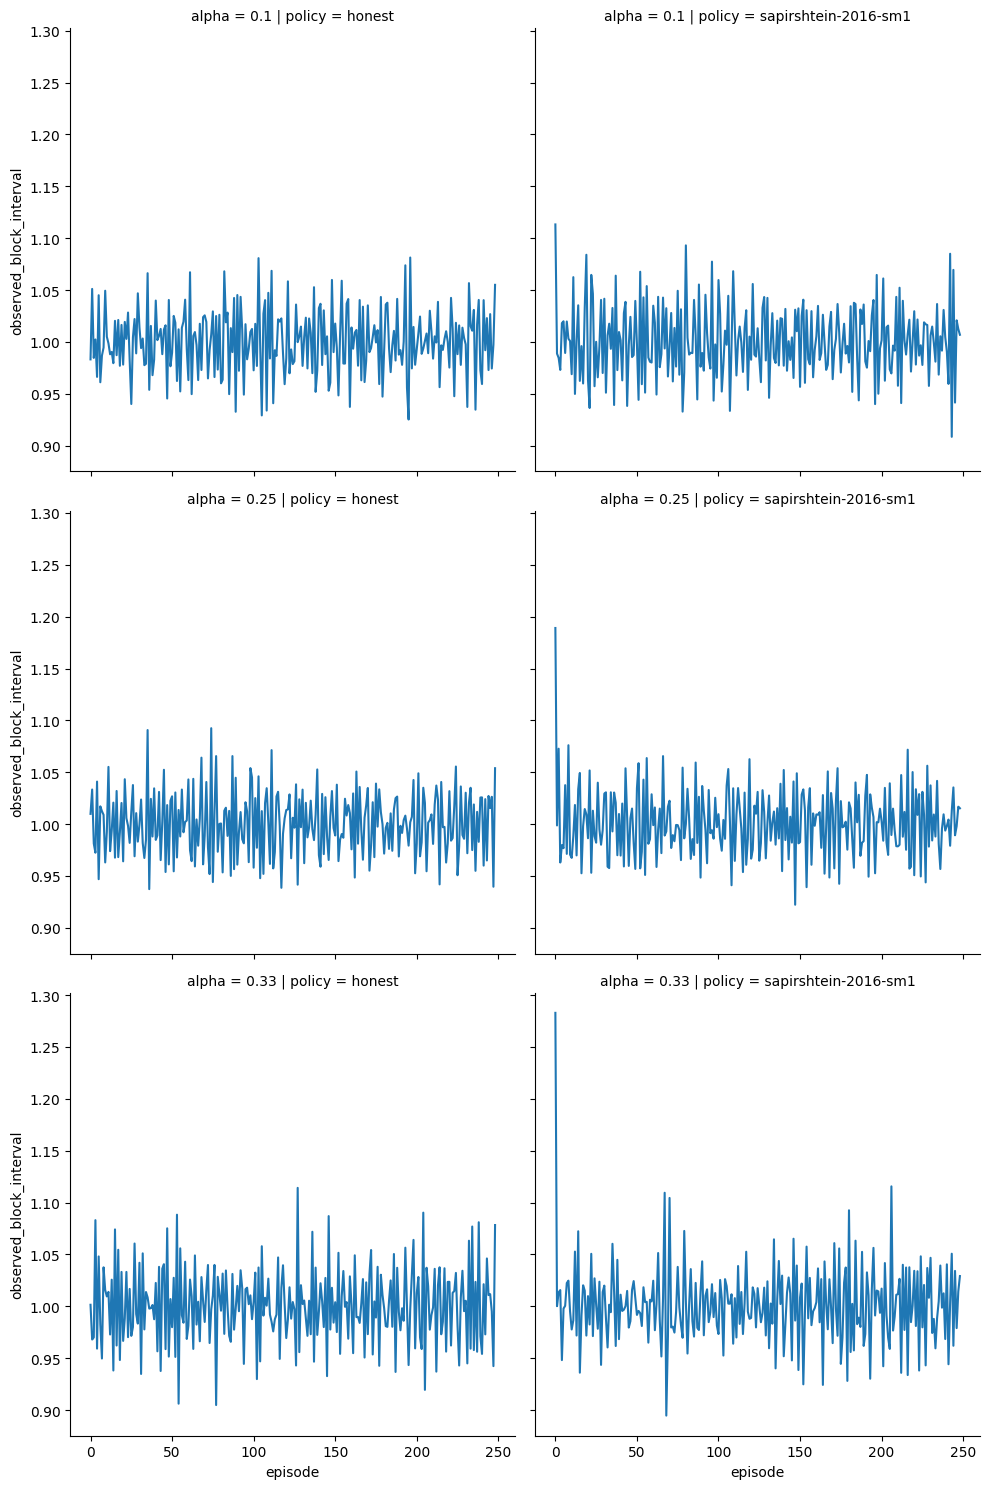

In [6]:
sns.relplot(data=d, kind="line", x="episode", y="observed_block_interval", col="policy", row="alpha")